# Objective of the Exploration
* Provide summary statistics
    * Descriptive Statistics
* Determine operating cost of individual power plants
* Show how fuel costs impact the viability of the different generation sources
* Highlight the competitiveness of renewable electricity
* Show how the generation mix of different utilities evolved overtime

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('raw_data.csv')
df.head(5)

,record_id,utility_id_ferc1,report_year,plant_name_ferc1,fuel_type_code_pudl,fuel_unit,fuel_qty_burned,fuel_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.590,18.59,18.53,1.121
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.592,18.58,18.53,1.120
2,f1_fuel_1994_12_2_0_1,2,1994,gorgas,coal,ton,2978683.0,24.130,39.72,38.12,1.650
3,f1_fuel_1994_12_2_0_7,2,1994,barry,coal,ton,3739484.0,23.950,47.21,45.99,1.970
4,f1_fuel_1994_12_2_0_10,2,1994,chickasaw,gas,mcf,40533.0,1.000,2.77,2.77,2.570


In [4]:
df.columns

Index(['record_id', 'utility_id_ferc1', 'report_year', 'plant_name_ferc1',
       'fuel_type_code_pudl', 'fuel_unit', 'fuel_qty_burned',
       'fuel_mmbtu_per_unit', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_cost_per_mmbtu'],
      dtype='object')

In [5]:
# rename columns
df.columns = ['record_id', 'utility_id', 'year', 'plant_name',
              'type', 'unit', 'qty_burned', 'mmbtu_PU',
              'cost_PU_burned', 'cost_PU_delivered', 'cost_per_mmbtu']

In [6]:
# compute values for summary statistcs
a = len(df)
b = len(df['utility_id'].unique())
c = '{}-{}'.format(df['year'].min(), df['year'].max())
d = len(df['plant_name'].unique())
e = len(df['type'].unique())

In [7]:
summ = {'Item': ['Records', 'Utilities', 'Period', 'Plants', 'Sources'], \
       'Value': [a, b, c, d, e]}
sum_table = pd.DataFrame(summ)
sum_table.set_index('Item', inplace=True)
sum_table.transpose()

Item,Records,Utilities,Period,Plants,Sources
Value,29523,185,1994-2018,2315,6


This simple record summary shows how much investment is made on electricity across the United States. 2307 plants accross the country is a rather large number in a bid to provide stable and improved energy for household and organisations.

## Data Cleaning

In [8]:
# check data types
df.dtypes

record_id             object
utility_id             int64
year                   int64
plant_name            object
type                  object
unit                  object
qty_burned           float64
mmbtu_PU             float64
cost_PU_burned       float64
cost_PU_delivered    float64
cost_per_mmbtu       float64
dtype: object

Every column looks well formatted except year formatted as int64. But since it only contains year, it will be left as is.

In [9]:
# check for duplicates
df.duplicated().any()

False

In [10]:
# check for missing values
df.isnull().sum()

record_id              0
utility_id             0
year                   0
plant_name             0
type                   0
unit                 180
qty_burned             0
mmbtu_PU               0
cost_PU_burned         0
cost_PU_delivered      0
cost_per_mmbtu         0
dtype: int64

Only unit column has missing values. Since it's relating to fuel type, we will fill the missing values based on most occured for unique fuel types.

In [11]:
df['unit'].unique()

array(['ton', 'mcf', 'kgU', 'bbl', 'gramsU', nan, 'mwdth', 'mmbtu',
       'mwhth', 'gal'], dtype=object)

In [12]:
df['unit'] = df.groupby('type')['unit'].apply(lambda x : x.fillna(x.value_counts().index[0]))

In [13]:
# comfirm imputation
df['unit'].isnull().sum()

0

Round all figures to two decimal places

In [14]:
cols = ['mmbtu_PU', 'cost_PU_burned', 'cost_PU_delivered',
       'cost_per_mmbtu']

In [15]:
df[cols] = df[cols].apply(lambda x : x.round(2))

In [16]:
df.head(2)

,record_id,utility_id,year,plant_name,type,unit,qty_burned,mmbtu_PU,cost_PU_burned,cost_PU_delivered,cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.59,18.59,18.53,1.12
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.59,18.58,18.53,1.12


## Feature Engineering
From exloration and understanding of the dataset, it was discovered that fuel cost per unit burned is already in mmbtu because fuel cost per mmbtu multiplied by fuel mmbtu per unit is equals to fuel cost per unit burned with few approximation lapses. Therefore, fuel cost per unit burned is the fuel cost in mmbtu. <br>
Based on the above, three new features will be created.
* Total Energy will be created by multiplying quantity burned by fuel mmbtu per unit.
* Total Energy/Fuel cost will be created by multiplying total energy by fuel cost per mmbtu
* Electricity/kWh will be created by dividing total energy by 3412.

In [83]:
df['total_energy'] = (df['qty_burned'] * df['mmbtu_PU']).round(2)
df['total_energy/fuel_cost'] = (df['total_energy'] * df['cost_per_mmbtu']).round(2)
df['kWh'] = (df['total_energy'] / 3412).round(2)

## Summary Statistics

In [84]:
# check desccriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
utility_id,29523.0,1.186018e+02,7.417835e+01,1.00,55.000,122.00,1.760000e+02,5.140000e+02
year,29523.0,2.005806e+03,7.025483e+00,1994.00,2000.000,2006.00,2.012000e+03,2.018000e+03
qty_burned,29523.0,2.622119e+06,9.118004e+06,1.00,13817.000,253322.00,1.424034e+06,5.558942e+08
mmbtu_PU,29523.0,8.491992e+00,1.060027e+01,0.00,1.020,5.76,1.701000e+01,3.412600e+02
cost_PU_burned,29523.0,2.086490e+02,2.854490e+03,-276.08,5.205,26.00,4.711000e+01,1.393580e+05
cost_PU_delivered,29523.0,9.175704e+02,6.877593e+04,-874.94,3.780,17.37,4.213500e+01,7.964521e+06
cost_per_mmbtu,29523.0,1.930434e+01,2.091541e+03,-41.50,1.940,4.13,7.745000e+00,3.592780e+05
total_energy,29523.0,1.444295e+07,1.024990e+08,0.00,33861.870,468917.00,1.248096e+07,1.284672e+10
total_energy/fuel_cost,29523.0,2.999413e+07,1.505306e+08,-19526.58,244489.150,2722800.08,2.682217e+07,1.888467e+10
kWh,29523.0,4.232986e+03,3.004073e+04,0.00,9.925,137.43,3.657960e+03,3.765157e+06


In [85]:
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib.dates as mdates

In [86]:
cols = ['qty_burned', 'mmbtu_PU', 'cost_PU_burned', 'cost_PU_delivered', 'cost_per_mmbtu', 'total_energy', 'total_energy/fuel_cost', 'kWh']

<Figure size 432x288 with 0 Axes>

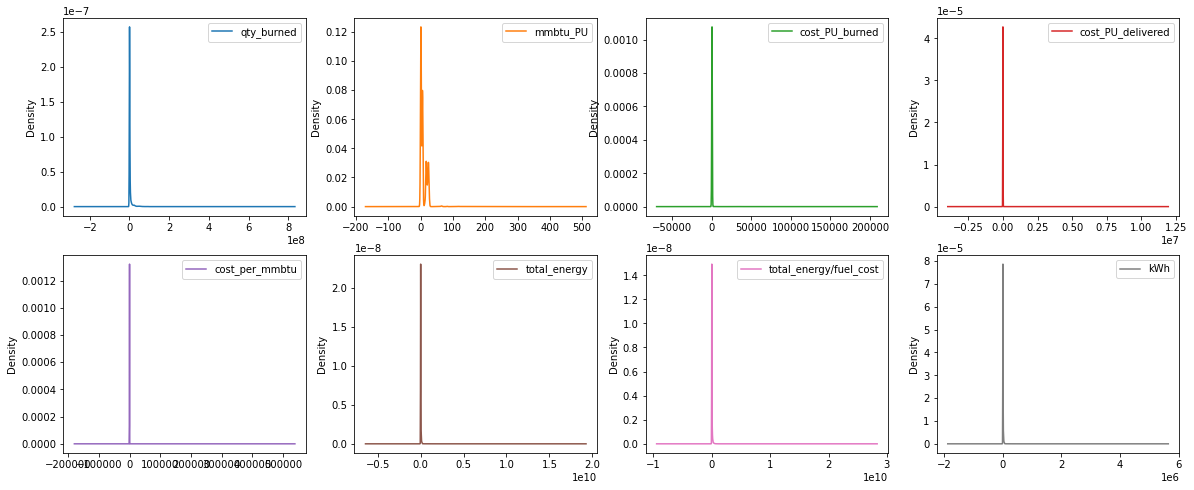

In [87]:
fig = plt.figure()
df[cols].plot(kind='kde', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(20,8))
plt.show()

The distribution plots above show that the dataset is skewed to the right. Since missing values were only found in the categorical variable column, this means that there are outliers in the dataset.

In [88]:
# replace outliers with median value as mean value is affected by outliers
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1 * 1.5
df[cols] = np.where(((df[cols] > Q3 + IQR) | (df[cols] < Q1 - IQR)), df[cols].median(), df[cols])

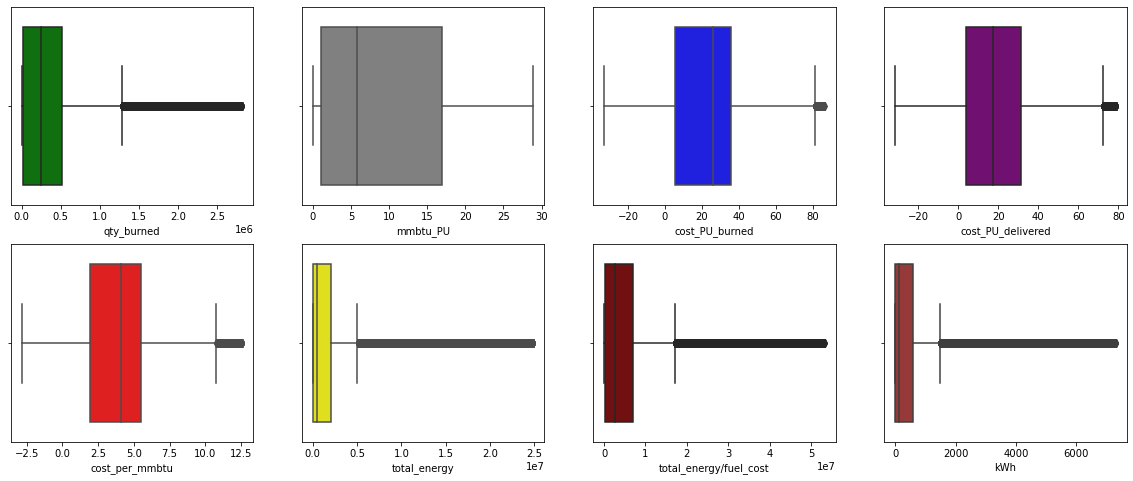

In [89]:
# show boxplot after removing outliers
fig = plt.figure(figsize=(20,8))
ax0 = fig.add_subplot(2,4,1)
ax1 = fig.add_subplot(2,4,2)
ax2 = fig.add_subplot(2,4,3)
ax3 = fig.add_subplot(2,4,4)
ax4 = fig.add_subplot(2,4,5)
ax5 = fig.add_subplot(2,4,6)
ax6 = fig.add_subplot(2,4,7)
ax7 = fig.add_subplot(2,4,8)
sns.boxplot(df[cols[0]], ax=ax0, color='g')
sns.boxplot(df[cols[1]], ax=ax1, color='grey')
sns.boxplot(df[cols[2]], ax=ax2, color='b')
sns.boxplot(df[cols[3]], ax=ax3, color='purple')
sns.boxplot(df[cols[4]], ax=ax4, color='red')
sns.boxplot(df[cols[5]], ax=ax5, color='yellow')
sns.boxplot(df[cols[6]], ax=ax6, color='maroon')
sns.boxplot(df[cols[7]], ax=ax7, color='brown')
plt.show()

Seeing the visualzation above, it becomes clear that the most used source of electricity from 1994 to 2018 used gas, followed by coal. Save the _other_ category, the least generated is waste.

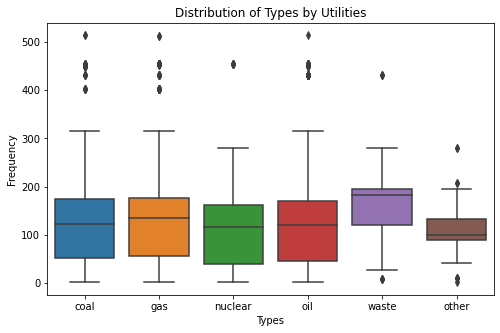

In [97]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x='type', y='utility_id', data=df)
ax.set_title('Distribution of Types by Utilities')
ax.set_xlabel('Types')
ax.set_ylabel('Frequency')
plt.show()

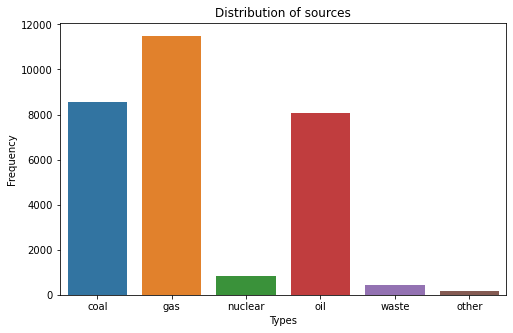

In [98]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(df['type'])
ax.set_title('Distribution of sources')
ax.set_xlabel('Types')
ax.set_ylabel('Frequency')
plt.show()

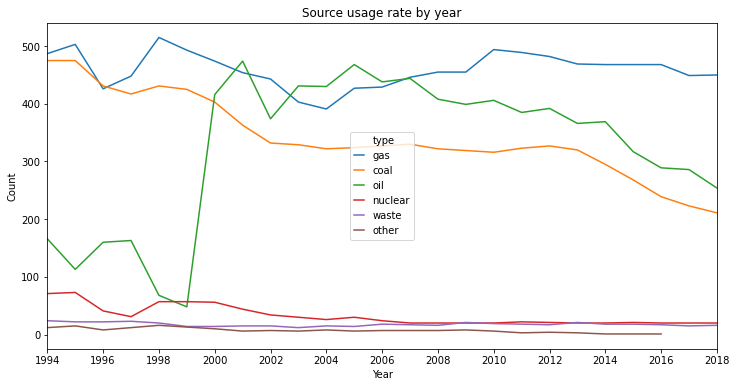

In [131]:
usage = df.groupby('year').agg({'type':'value_counts'})
usage.columns = ['count']
usage.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(x='year', y='count', hue='type', data=usage)
ax.set_title('Source usage rate by year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_xlim(1994,2018)
plt.xticks(np.arange(1994, 2018+1, 2))
ax.legend(loc='center', handlelength=1)
plt.show()

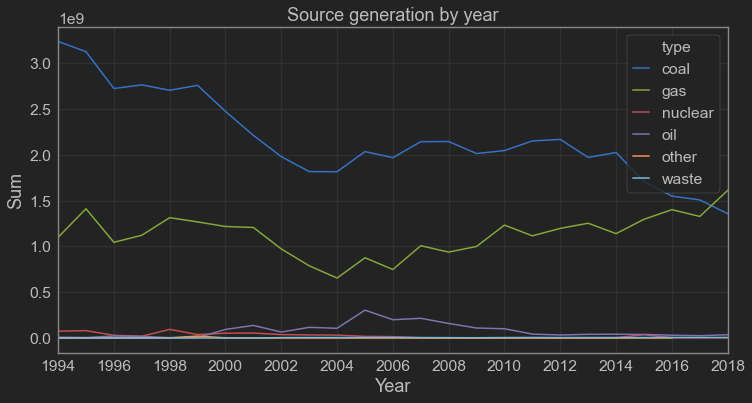

In [146]:
gen = df.groupby(['year', 'type']).agg({'total_energy':'sum'})
gen.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(x='year', y='total_energy', hue='type', data=gen)
ax.set_title('Source generation by year')
ax.set_xlabel('Year')
ax.set_ylabel('Sum')
ax.set_xlim(1994,2018)
plt.xticks(np.arange(1994, 2018+1, 2))
ax.legend(loc='upper right', handlelength=1)
plt.show()

In [141]:
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)

In [164]:
mix = pd.concat([gen.loc[gen['type'] == 'coal', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'gas', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'nuclear', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'oil', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'waste', ['year', 'total_energy']].set_index('year'),
                gen.loc[gen['type'] == 'other', ['year', 'total_energy']].set_index('year')], join='outer', axis=1)
mix.columns = ['coal', 'gas', 'nuclear', 'oil', 'waste', 'other']

In [143]:
color = ['#050516', 'maroon', '#6C674A', 'magenta', '#007ED6', '#FF7300']

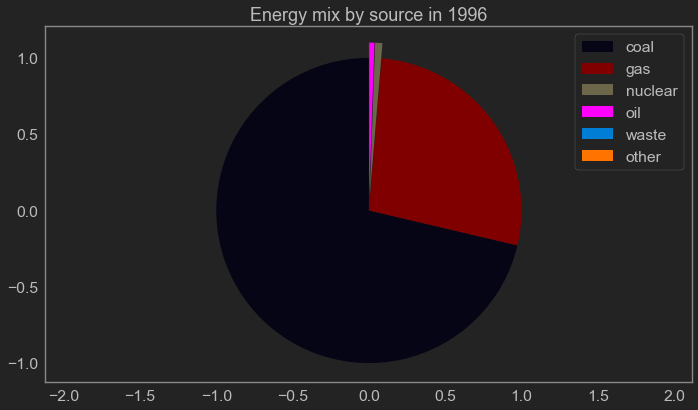

In [167]:
mix_chart = mix.loc[1996]
mix_chart.plot(kind='pie',
             colors = color,
             figsize=(10,6),
             startangle=(90),
             pctdistance=0.6,
             explode=[0,0,0.1,0.1,0.1,0.1], frame=True,
             autopct=None, labels=None, legend=True),
plt.title('Energy mix by source in {}'.format(mix_chart.name))
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.savefig('pie.png', dpi=200)
plt.show()

## Operational Cost Per Plant

### Annual Operational Cost for Individual Plants

### Showing how fuel costs impact the viability of the different generation sources

### Showing competition among sources over time